# Synthetic credit card fraud dataset

In [44]:
import pandas as pd
import warnings
import math
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score, average_precision_score
%matplotlib inline
warnings.simplefilter(action='ignore', category=FutureWarning)

### EDA

In [47]:
fraud = pd.read_csv('fraud.csv', delimiter=',')

In [48]:
fraud.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [49]:
fraud.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [50]:
fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
step              int64
type              object
amount            float64
nameOrig          object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest          object
oldbalanceDest    float64
newbalanceDest    float64
isFraud           int64
isFlaggedFraud    int64
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [58]:
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['oldbalanceDest'].loc[fraud.oldbalanceDest == 0].count()))
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['oldbalanceOrg'].loc[fraud.oldbalanceOrg == 0].count()))
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['newbalanceDest'].loc[fraud.newbalanceDest == 0].count()))
print("The amount of empty empty destination accounts before the transfer :" + str(fraud['newbalanceOrig'].loc[fraud.newbalanceOrig == 0].count()))
print("The amount transfers in the dataset :" + str(len(fraud)))

The amount of empty empty destination accounts before the transfer :2704388
The amount of empty empty destination accounts before the transfer :2102449
The amount of empty empty destination accounts before the transfer :2439433
The amount of empty empty destination accounts before the transfer :3609566
The amount transfers in the dataset :6362620


### isFraud

Transactions which were fraudulent

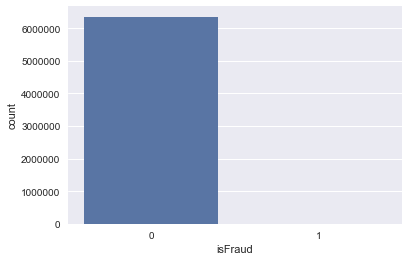

In [291]:
sns.countplot(x="isFraud", data=fraud)

In [293]:
# Proportion of yes/no

# we'll start off by counting the total number of people who did and didn't subscribe
ycount = fraud['isFraud'].value_counts()
# we need to count the number of total observations
rowcount = fraud.shape[0]-1

print('Proportion yes: ' + '{0:2.3f}'.format((ycount[1]/rowcount)))
print('Proportion no: ' + '{0:2.3f}'.format((ycount[0]/rowcount)))

# We'll save the overall proportion of successes as the variable expected, this will help us with our chi squared tests
expected = ycount[1]/rowcount

Proportion yes: 0.001
Proportion no: 0.999


### newbalanceOrig

Is the balance of the origin account after the transaction

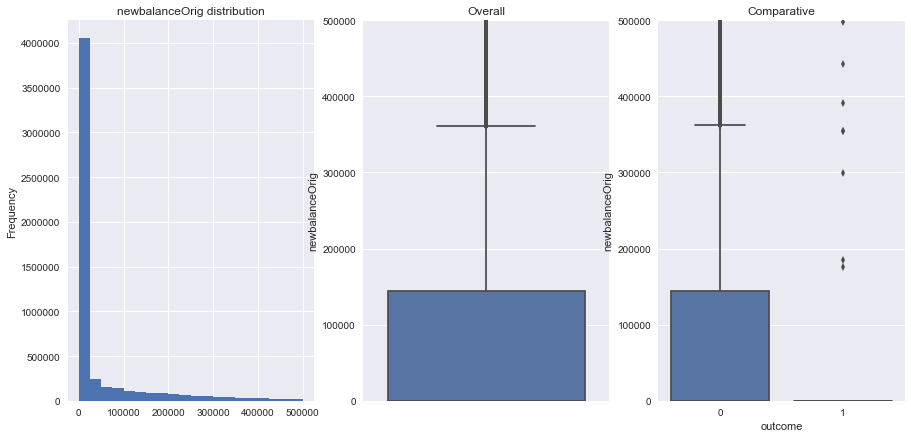

In [294]:
plt.subplot(1, 3, 1)
amountplt = fraud.newbalanceOrig.plot( kind='hist', bins = 20, figsize=(15,7), range=(0,500000))
#plt.xlabel('oldbalanceOrg')
plt.title('newbalanceOrig distribution')

plt.subplot(1, 3, 2)
newbalanceOrigbox = sns.boxplot(y="newbalanceOrig", data=fraud)
#newbalanceOrigbox.set_yscale('log')
plt.ylim(0, 500000)
plt.ylabel('newbalanceOrig')
plt.title('Overall')

plt.subplot(1, 3, 3)
newbalanceOrigbox2 = sns.boxplot(x="isFraud", y="newbalanceOrig", data=fraud)
#newbalanceOrigbox2.set_yscale('log')
plt.ylim(0, 500000)
newbalanceOrigbox2.set(xlabel='outcome')
plt.title('Comparative')

### oldbalanceOrg

Is the balance of the origin account before the transaction

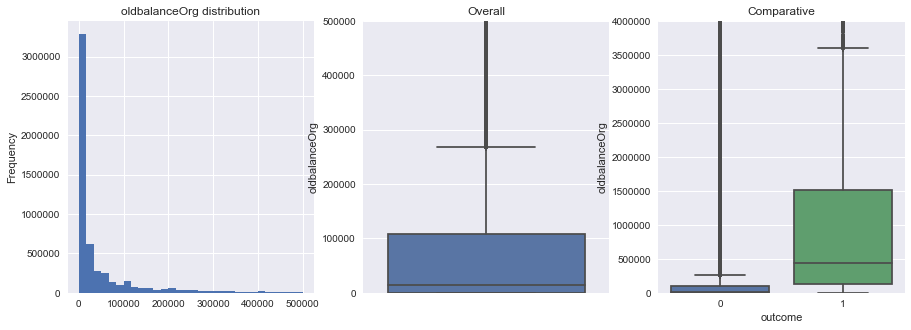

In [295]:
plt.subplot(1, 3, 1)
amountplt = fraud.oldbalanceOrg.plot( kind='hist', bins = 30, figsize=(15,5), range=(0,500000))
#plt.xlabel('oldbalanceOrg')
plt.title('oldbalanceOrg distribution')

plt.subplot(1, 3, 2)
oldbalanceOrgbox = sns.boxplot(y="oldbalanceOrg", data=fraud)
#oldbalanceOrgbox.set_yscale('log')
plt.ylim(0, 500000)
plt.ylabel('oldbalanceOrg')
plt.title('Overall')


plt.subplot(1, 3, 3)
oldbalanceOrgbox2 = sns.boxplot(x="isFraud", y="oldbalanceOrg", data=fraud)
#oldbalanceOrgbox2.set_yscale('log')
plt.ylim(0, 4000000)
oldbalanceOrgbox2.set(xlabel='outcome')
plt.title('Comparative')

### Amount

Is the amount of money which was transacted

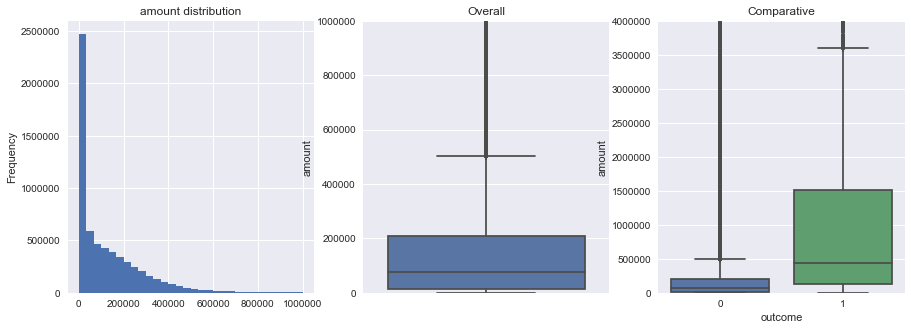

In [296]:
plt.subplot(1, 3, 1)
amountplt = fraud.amount.plot( kind='hist', bins = 30, range=(0,1000000), figsize=(15,5))
#plt.xlabel('amount')
plt.title('amount distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="amount", data=fraud)
#stepbox.set_yscale('log')
plt.ylim(0, 1000000)
#plt.ylabel('Amount')
plt.title('Overall')

plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(x="isFraud", y="amount", data=fraud)
#stepbox2.set_yscale('log')
plt.ylim(0, 4000000)
stepbox2.set(xlabel='outcome')
plt.title('Comparative')

### newbalanceDest

Is the balance of the destination account after the transaction

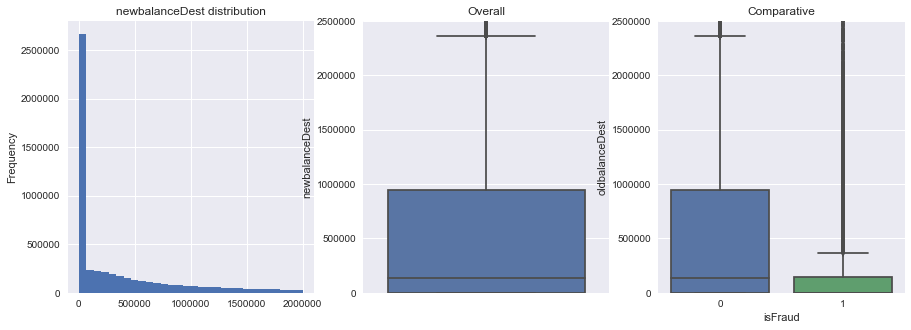

In [297]:
plt.subplot(1, 3, 1)
newbalanceDestplt = fraud.newbalanceDest.plot( kind='hist', bins = 30, figsize=(15,5), range=(0,2000000))
#plt.xlabel('newbalanceDest')
plt.title('newbalanceDest distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="oldbalanceDest", data=fraud)
plt.ylim(0, 2500000)
#stepbox.set_yscale('log')
plt.ylabel('newbalanceDest')
plt.title('Overall')


plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(y="oldbalanceDest", x="isFraud", data=fraud)
plt.ylim(0, 2500000)
#stepbox2.set_yscale('log')
plt.xlabel=('outcome')
plt.title('Comparative')

### Type

Is the type of transaction which occurred

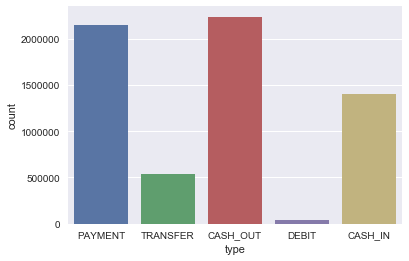

In [298]:
sns.countplot(x="type", data=fraud)

Here are the transfers which were fraudulent

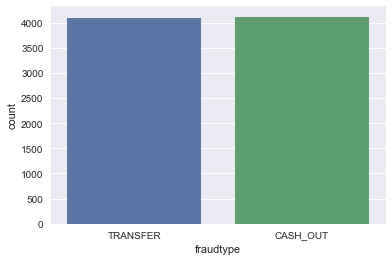

In [299]:
fraud['fraudtype'] = fraud['type'].loc[fraud.isFraud == 1]
sns.countplot(x="fraudtype", data=fraud)

### Step

This variable represents a one hour step during the 31 day month

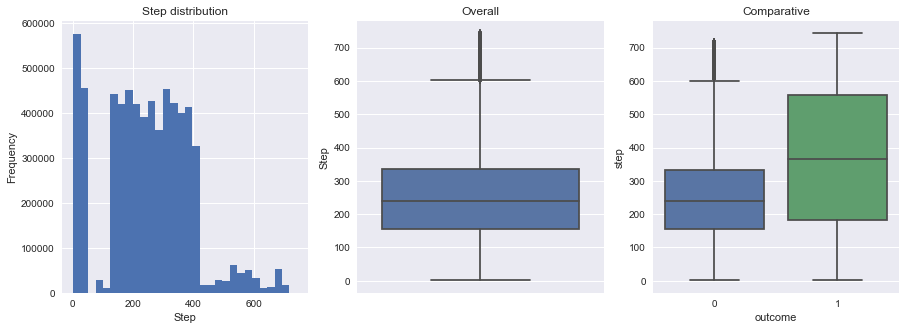

In [7]:
plt.subplot(1, 3, 1)
stepplt = fraud.step.plot( kind='hist', bins = 30, figsize=(15,5))
plt.xlabel('Step')
plt.title('Step distribution')

plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="step", data=fraud)
plt.ylabel('Step')
plt.title('Overall')


plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(x="isFraud", y="step", data=fraud)
stepbox2.set(xlabel='outcome')
plt.title('Comparative')

### oldbalanceDest

Is the balance of the destination account before the transaction

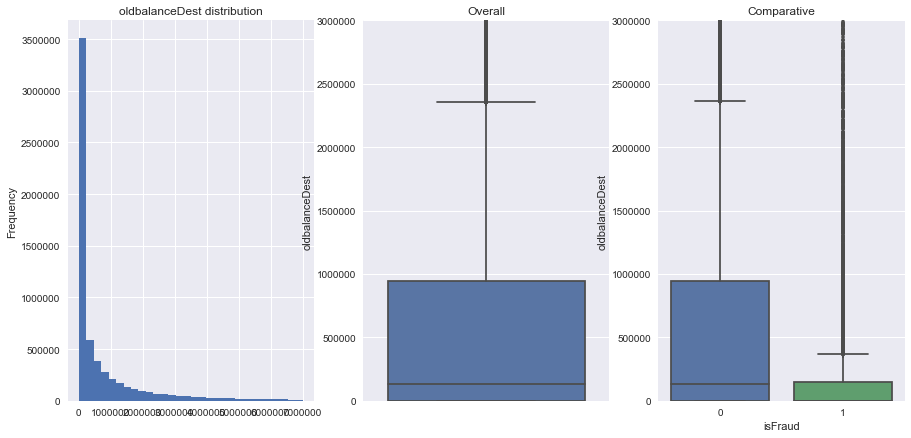

In [302]:
plt.subplot(1, 3, 1)
oldbalanceDestplt = fraud.oldbalanceDest.plot(kind='hist', bins = 30, figsize=(15,7), range=(0,7000000))
#plt.xlabel('oldbalanceDest')
plt.title('oldbalanceDest distribution')


plt.subplot(1, 3, 2)
stepbox = sns.boxplot(y="oldbalanceDest", data=fraud)
#stepbox.set_yscale('log')
plt.ylim(0, 3000000)
plt.ylabel('oldbalanceDest')
plt.title('Overall')


plt.subplot(1, 3, 3)
stepbox2 = sns.boxplot(y="oldbalanceDest", x="isFraud", data=fraud)
#stepbox2.set_yscale('log')
plt.ylim(0, 3000000)
plt.xlabel=('outcome')
plt.title('Comparative')

## Data cleaning and feature engineering

Steps we take to clean the data:
-  We clear all of the rows where the transaction type is not transfer or cashout, the reason for this is we do not observe any cases of fraud in these two columns and thus they are not useful to us.
- We use a label encoder to convert the categorical variable to numerical placeholders
- We drop the old categorical columns and split the data into an input dataframe X, and an output dataframe y which contains out binary outcome variable

In [31]:
fraud = fraud.loc[(fraud.type == 'TRANSFER') | (fraud.type == 'CASH_OUT')]

In [32]:
fraud["hours"] = fraud["step"].apply(lambda x: x%24)

In [34]:
lb_make = LabelEncoder()

categories = ['type', 'nameOrig', 'nameDest', 'prefix_Orig_CASHIN_M']#, 'prefix_Orig_CASHIN_M', 'prefix_Orig_CASHIN_C', 'prefix_Orig_CASHOUT_M', 'prefix_Orig_CASHOUT_C', 'prefix_Orig_TRANSFER_M', 'prefix_Orig_TRANSFER_C']
for col in categories: 
    fraud[str(col)+"_code"] = lb_make.fit_transform(fraud[col]) 

C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


#### Features

There are many errors in the balance in the original and destination accounts, we create a feature for the origin and destination accounts which measure how large this error was

In [35]:
fraud['errorBalanceOrig'] = fraud.newbalanceOrig + fraud.amount - fraud.oldbalanceOrg
fraud['errorBalanceDest'] = fraud.oldbalanceDest + fraud.amount - fraud.newbalanceOrig

We create a second feature to tell us the prefix of the origin of the cash in transaction. The M prefix tells us that the origin of the cash in was a merchant, the alternative is that it came from a customer. Adding this feature is useful as it will allow the model to differentiate between transactions which come from merchants vs customers

In [33]:
fraud["prefix_Orig_CASHIN_M"] = fraud.loc[fraud.type == 'CASH_IN'].nameOrig.str.contains('M')

We then drop the categorical columns which have been encoded, and we split the dataset into input and output variables

In [36]:
fraud = fraud.sample(1000000)

In [37]:
X = fraud.drop(['isFraud', 'isFlaggedFraud', 'type', 'nameOrig', 'nameDest', 'prefix_Orig_CASHIN_M'], axis=1)#, 'prefix_Orig_CASHIN_M', 'prefix_Orig_CASHIN_C', 'prefix_Orig_CASHOUT_M', 'prefix_Orig_CASHOUT_C', 'prefix_Orig_TRANSFER_M', 'prefix_Orig_TRANSFER_C', 'prefixNameOgig'], axis=1)
y = fraud['isFraud']

#### Model Creation

We split the data into a testing and training set, and then convert the dataframes into a dmatrix (data structure optimised for XGBoost)

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [39]:
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

We then build a graph to show how each successive round of boosting improves or deproves the score of the model. For this evaluation we will use mean average precision (MAP)

In [40]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate":0.069, "subsample":0.91, "colsample_bytree":0.95}

# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, num_boost_round=400, as_pandas=True, metrics='map', nfold=15, seed=27)
results = pd.DataFrame(cv_results)
results['round'] = range(1, len(results) + 1)

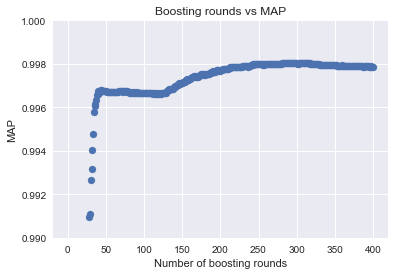

In [41]:
plt.scatter(results['round'], results['test--mean'])
plt.ylim(0.99, 1)
plt.xlabel('Number of boosting rounds')
plt.ylabel('MAP')
plt.title('Boosting rounds vs MAP')

From the graph above we can see that MAP peaks at around 270, and after the model starts to overfit the training data, leading to a decrease in the MAP of the test data

In [42]:
# Create the parameter dictionary for each tree (boosting round)
params = {"objective":"reg:logistic", "max_depth":3, "learning_rate":0.069, "subsample":0.8, "colsample_bytree":0.95, "gamma":0.12}
    
# Perform cross-validation: cv_results
cv_results = xgb.cv(dtrain=dmatrix, params=params, metrics="map", as_pandas=True, num_boost_round=300, nfold=13, seed=42)
#print(cv_results[-1:])
print(cv_results)

     test--mean  test--std  train--mean  train--std
0      0.612030   0.023880     0.617693    0.013245
1      0.635726   0.042208     0.638597    0.016901
2      0.654425   0.040573     0.655268    0.021436
3      0.663242   0.033159     0.662661    0.019488
4      0.675128   0.029631     0.676524    0.017552
5      0.680663   0.029719     0.684859    0.012837
6      0.692846   0.038613     0.694512    0.023318
7      0.700976   0.035905     0.702876    0.017304
8      0.706733   0.035776     0.708388    0.020986
9      0.708924   0.037021     0.712030    0.022606
10     0.716251   0.034212     0.717562    0.024744
11     0.732202   0.069548     0.732158    0.063884
12     0.762281   0.087623     0.765441    0.081671
13     0.809661   0.100170     0.814657    0.094415
14     0.835243   0.094114     0.836612    0.090761
15     0.837525   0.094014     0.838687    0.090819
16     0.843375   0.101085     0.844526    0.098053
17     0.863345   0.095079     0.861050    0.098498
18     0.895

We then fit the model to our testing data which until now has been left untouched. To do this we fit the model to to the training data using the XGBClassifier, we use it to predict the probability that a given transaction is fraudulent. I have exported the results of the test to CSVs so that I can analyse the results, however I plan on graphing the results in python so that we can visualise the tradeoff between the precision and recall of the model

In [50]:
clf = xgb.XGBClassifier(max_depth = 3, n_estimators=200, objective="reg:logistic", learning_rate=0.069, subsample=0.91, colsample_bytree=0.95, gamma=0.13)

In [51]:
clf.fit(X_train, y_train)
probabilities = clf.predict_proba(X_test)

In [52]:
probabilities =pd.DataFrame(probabilities)
probabilities.to_csv("probabilities.csv")
y_test.to_csv("target")

We construct a graph to visualise the importance of our features

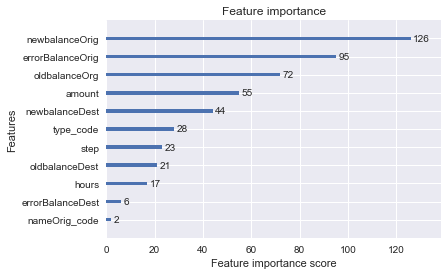

In [169]:
model = xgb.train(params=params, dtrain=dmatrix, num_boost_round=100)
xgb.plot_importance(model, xlabel='Feature importance score',)
plt.show()